<div style="text-align:center">
    <h1>
        REINFORCE
    </h1>
</div>

<br><br>

<div style="text-align:center">
In this notebook we are going to implement the Monte Carlo version of Policy Gradient methods. The REINFORCE algorithm uses the full return to update the policy:
</div>

\begin{equation}
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+1} + \cdots + \gamma^{T-t-1} R_{T}
\end{equation}


<br>

In [1]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



# !pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
import torch
from matplotlib import animation
import matplotlib.patches as mpatches

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def seed_everything(env: gym.Env, seed: int = 42) -> None:
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


def test_policy_network(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)


def plot_action_probs(probs, labels):
    plt.figure(figsize=(6, 4))
    plt.bar(labels, probs, color ='orange')
    plt.title("$\pi(s)$", size=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()




## Import the necessary software libraries:

In [2]:
import os
import torch
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW

## Create and preprocess the environment

### Create the environment

In [3]:
env = gym.make('CartPole-v0')

d:\anaconda3\Lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [4]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 4. Actions: 2
Sample state: [ 0.00115274  0.01135306 -0.04249491  0.02670137]


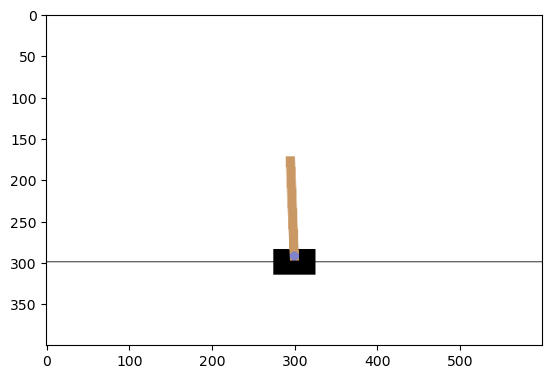

In [5]:
plt.imshow(env.render(mode='rgb_array'))

### Prepare the environment to work with PyTorch

In [6]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state).float()

    def step(self, actions):
        #actions are going to be column vector
        #[[3],
        #[2],
        #[1]]->[3,2,1]
        actions = actions.squeeze().numpy()#squeeze method removes the unnecessary dimension from the tensor and then we call the numpy method to convert the tensor into numpy array in order
        #to work with the environment
        next_state, reward, done, info = self.env.step(actions)#this is a recursive call, it will not stop!? what are we doing here?
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()#we could implement the same functionlity as .view with this .unsqueeze functionality
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [7]:
num_envs = os.cpu_count()
parallel_env = gym.vector.make('CartPole-v1', num_envs=num_envs)
seed_everything(parallel_env)
parallel_env = PreprocessEnv(parallel_env)

In [8]:
state= parallel_env.reset()
_, reward, done, _ = parallel_env.step(torch.zeros(num_envs, 1, dtype=torch.int32))
#because we are working with parallel environments, we will have to pass it a column vector ( and a tensor) of actions num_envs, 1 is the dimension of the vector that will be passed
print(f"State :{state}, reward :{reward}, done :{done}")

State :tensor([[ 0.0274, -0.0061,  0.0359,  0.0197],
        [ 0.0152, -0.0456, -0.0480,  0.0339],
        [-0.0377, -0.0242, -0.0094,  0.0469],
        [ 0.0073,  0.0028,  0.0264,  0.0312],
        [ 0.0406, -0.0423, -0.0227,  0.0122],
        [ 0.0242,  0.0254, -0.0035, -0.0396],
        [-0.0112,  0.0096,  0.0014,  0.0194],
        [-0.0137,  0.0093, -0.0108,  0.0124],
        [ 0.0287,  0.0334,  0.0048,  0.0473],
        [ 0.0442, -0.0193, -0.0245, -0.0277],
        [ 0.0116,  0.0074,  0.0020, -0.0494],
        [-0.0489,  0.0219, -0.0169,  0.0433],
        [-0.0278,  0.0019, -0.0420,  0.0077],
        [ 0.0332,  0.0371, -0.0282, -0.0270],
        [ 0.0226, -0.0483,  0.0481,  0.0225],
        [ 0.0184, -0.0032,  0.0341, -0.0160]]), reward :tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), done :tensor([[False]

### Create the policy $\pi(s)$

In [9]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1)#in the previous notebook, print the output of the neural network in the algorithm section, where state was passsed into the network and output were the q-values
    #i think the logic behind the dim=-1 is just to apply the Softmax function on the necesssary data
)

### Plot action probabilities

In [10]:
neutral_state = torch.zeros(4)
left_danger = torch.tensor([-2.3, 0., 0., 0.])
right_danger = torch.tensor([2.3, 0., 0., 0.])

#### Plot a neutral environment

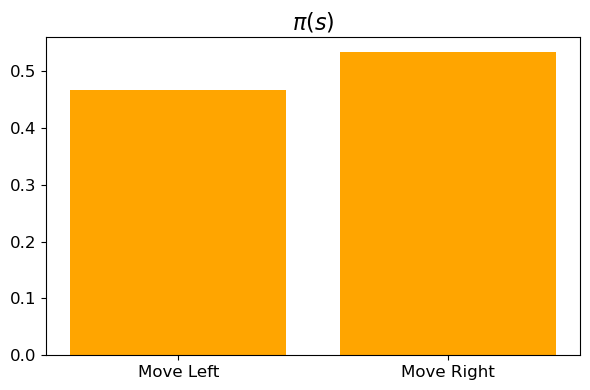

In [12]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

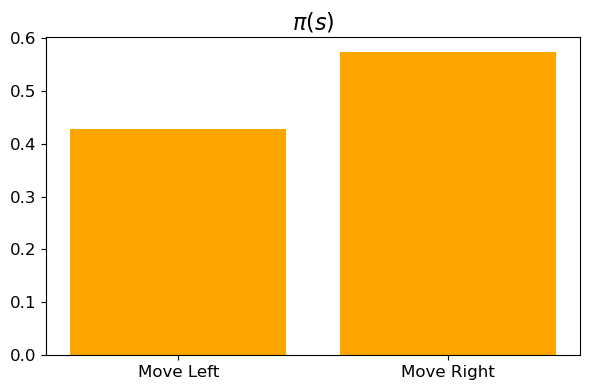

In [13]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

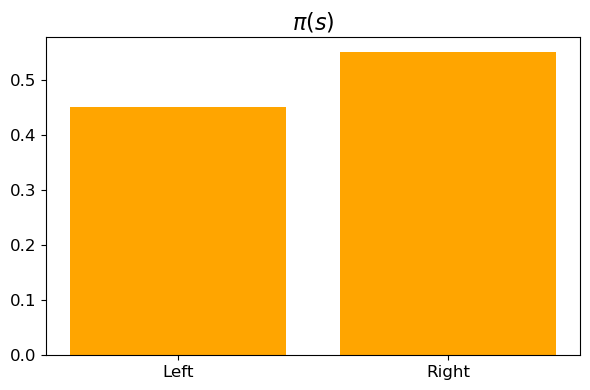

In [14]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

## Implement the algorithm

In [11]:
def reinforce(policy, episodes, alpha=0.0001, gamma=0.99):
    optim = AdamW(policy.parameters(), lr=alpha)
    stats = {'Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes+1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        transitions = []
        ep_return = torch.zeros(num_envs, 1)
        while not done_b.all():
            #action-probabilities -> action chosen
            #[0.1, 0.3, 0.5, 0.1] -> most of the time, action 2(indexing starts from zero) will be chosen as it has the highest probability, but other actions will be chosen as well.
            #the chosen actions will be a column vector as there are multiple environments, not just a single environment, so the action variable will be a column vector, eg.,
            #[[1]
            #[2]
            #[3]]
            action = policy(state).multinomial(1).detach()#detach method ensures that pytorch won't include these variables in the backpropagation mehtod that will be used to update the neural network
            next_state, reward, done_b, _ = parallel_env.step(action)
            transitions.append([state, action, ~done_b*reward])#~done.b*reward because rewards after terminal state are always zero, so ~done_b will make the rewards zero for all the environments whose
            #episode has already finished
            ep_return += reward
            done_b |= done #| is OR operation, in order to update the done-b variable for those environments whose episodes have finished
        #return vector(as there are multiple environments)
        G = torch.zeros((num_envs, 1))

        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transitions))):
            G = reward_t + gamma*G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t+1e-6)#we are adding 1e-6 as a small constant to keep the function consistent as log(0) is not defined
            #now we have to take out the probability from this vector, the action which was actually taken
            action_log_prob_t = log_probs_t.gather.gather(1, action_t)#1 denotes the dimension, which is vertically, as we will have a column vector and it is indexed by the action_t
            #now we will compute the entropy
            entropy_t = -torch.sum(probs_t * log_probs_t, dim=-1, keepdim=True)#dim=-1 ensures that the sum is applied independently and we get the sum of each individual parallel environment as a seperate
            #element in the tensor, and also, keepdim=True because pytorch whenever has the chance to reduce the dimensionality of the tensor, it performs it. To prevent pytorch from doing so
            #we need to pass this argument
            gamma_t = gamma ** t

            pg_loss_t = - gamma_t * action_log_prob_t * G #we wrote - ve because AdamW can only work with SGD, not SGA, so that is why we took negative of the loss, so that, 
            #even though it would be trying to decrease the loss, but actually, it would be increasing the performance

            total_loss_t = (pg_loss_t - 0.01 * entropy_t).mean()#what is the need for 0.01 factor and also, we are taking mean of all the error values across all the parallel environments
            #so that the total_loss_t would be a single value
            #plus, shouldn't it be + 0.01 * entropy_t?
            policy.zero_grad()
            total_loss_t.backward()#this backward method will launch the backpropagation algorithm to compute the gradients of the loss function with respect to each of the parameters of the
            #neural network
            optim.step()#this will perform the update rule
        
        stats['Loss'].append(total_loss_t.item())
        stats['Returns'].append(ep_return.mean().item())
    
    return stats


In [12]:
parallel_env.reset()
stats = reinforce(policy, 200)
#there is some code error here, see the commented code here for understanding, use the code given in the complete notebook for running

  0%|          | 0/200 [00:00<?, ?it/s]

## Show results

### Show execution stats

In [ ]:
plot_stats(stats)

### Plot action probabilities

#### Plot a neutral environment

In [ ]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

In [ ]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

In [ ]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

### Test the resulting agent

In [ ]:
test_policy_network(env, policy, episodes=5)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)